### Importing external libraries and modules

In [1]:
import numpy as np
import scipy as spy
from scipy.optimize import fsolve,bisect
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from scipy import interpolate
from numba import njit
import time

Things to implement
----------------
- two shock theory (both conservation equation and mach number relations)
- Three shock theory (both conservation equation and mach number relations)
- Asymmetric wedge reflections
- Shock polar solutions
- find the transition conditions
- mach stem heights

Functions
----------------
- phi solver
- Flow deflection angle (theta) solver
- downstream mach number
- downstream pressure and pressure ratio
- downstream density and density ratio
- downstream temperature and temperature ratio


In [2]:
# @njit
def cot(x):
    return 1/np.tan(x)

---
### Flow deflection angle (theta)

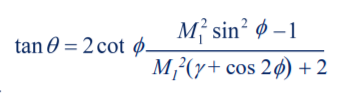

In [3]:
def flow_deflection_angle(phi,M_1,gamma=1.4): # theta
    
    tan_theta = 2*cot(phi)*((M_1*np.sin(phi))**2 - 1)/  \
                (M_1**2*(gamma+np.cos(2*phi))+2)
    return np.arctan(tan_theta)
    

---
### Wave angle

In [4]:
# @njit
def theta_phi_rel(phi,M_1,theta,gamma=1.4):
#         phi[phi<0] = np.abs(phi[phi<0])
        
        f_x = 2*cot(phi)*((M_1*np.sin(phi))**2 - 1)/ \
        (M_1**2*(gamma+np.cos(2*phi))+2)-  \
        np.tan(theta)
        return f_x

In [5]:
# theta_phi_rel(np.deg2rad(91),3,0)

In [6]:
def wave_angle(theta,M_1,phi_init=0.1,gamma=1.4): # phi or beta
    
#     def theta_phi_rel(phi,M_1,theta,gamma):
#         phi[phi<0] = np.abs(phi[phi<0])
        
#         f_x = 2*cot(phi)*((M_1*np.sin(phi))**2 - 1)/ \
#         (M_1**2*(gamma+np.cos(2*phi))+2)-  \
#         np.tan(theta)
#         return f_x
    phi_init = np.ones(np.shape(M_1))*phi_init
    phi = fsolve(theta_phi_rel,phi_init,args=(M_1,theta,gamma))
    return phi
    

In [7]:
def wave_angle_bisect(theta,M_1,bnd,gamma=1.4): # phi or beta
#     print(theta_phi_rel(bnd[0],M_1,0),theta_phi_rel(bnd[1],M_1,0))
    phi = bisect(theta_phi_rel,bnd[0],bnd[1],args=(M_1,theta,gamma))
    return phi

---
### Downstream mach number

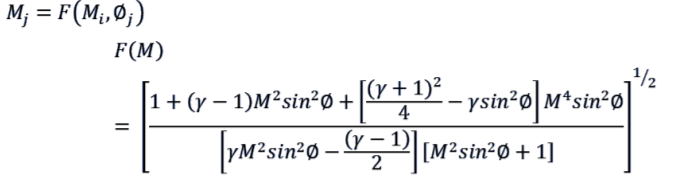

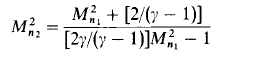

In [8]:
def downstream_mach_no(phi,theta,M_1,gamma=1.4):
    M_n1 = M_1*np.sin(phi)
#     num = (1+(gamma-1)*M_n1**2 + (0.25*(gamma+1)**2-gamma*np.sin(phi)**2)*(M_1*M_n1)**2)
#     den = ((gamma*M_n1**2-0.5*(gamma-1))*(M_n1**2+1))
#     print(num,den)
    M_n2 = np.sqrt((M_n1**2 + (2/(gamma-1)))/((2*gamma/(gamma-1))*M_n1**2-1))
    M_2  = M_n2/(np.sin(phi-theta))
    return M_2

---
### <u>Downstream pressure</u>

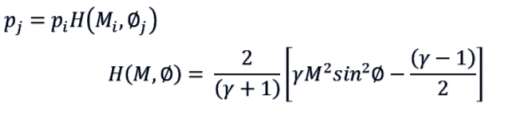

In [9]:
def downstream_pressure(phi,M_1,p_1,gamma=1.4):
    p_ratio = (2/(gamma+1))*(gamma*(M_1*np.sin(phi))**2-0.5*(gamma-1))
    return p_ratio*p_1,p_ratio
    

---
### <ins>Downstream density</ins>

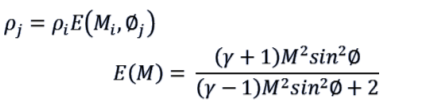

In [10]:
def downstream_density(phi,M_1,rho_1,gamma=1.4):
    rho_ratio = (gamma+1)*(M_1*np.sin(phi))**2/   \
                ((gamma-1)*(M_1*np.sin(phi))**2+2)
    return rho_ratio*rho_1, rho_ratio
    

---
### <ins>Downstream temperature</ins>

<!-- ![image.png](attachment:image.png) -->
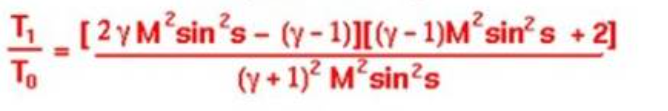

In [11]:
def downstream_temperature(phi,M_1,T_1,gamma=1.4):
    M_n1 = M_1*np.sin(phi)
    temp_ratio = ((2*gamma*M_n1**2-(gamma-1))*((gamma-1)*M_n1**2 + 2))/\
                 ((gamma+1)**2*M_n1**2)
    return temp_ratio*T_1, temp_ratio
    

---
### <ins>Oblique shock downstream values</ins>

In [12]:
def oblique_shock_downstream_values(M_1,theta,p_1=1,rho_1=1,T_1=1,gamma=1.4,strong=False):
    
    if strong==False:
        phi = wave_angle(theta,M_1,phi_init=0.1,gamma=gamma) # phi or beta 
    elif strong==True:
        _,phi_init,t_,_ = theta_phi_limits(M_1,gamma=gamma)
        phi = wave_angle(theta,M_1,phi_init+0.2,gamma=gamma) 
        
    M_2 = downstream_mach_no(phi,theta,M_1,gamma=1.4)
    p_2,p_2_p_1 = downstream_pressure(phi,M_1,p_1,gamma=1.4)
    rho_2,rho_2_rho_1 = downstream_density(phi,M_1,rho_1,gamma=1.4)
    T_2,T_2_T_1 = downstream_temperature(phi,M_1,T_1,gamma=1.4)
    
    return phi,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1
    

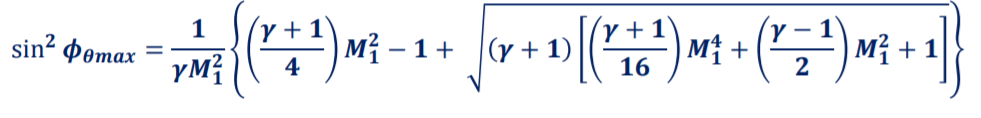
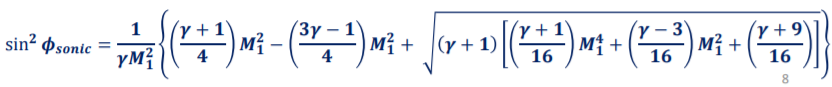
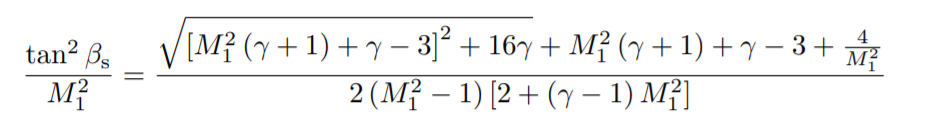
https://www.researchgate.net/publication/323164887_Analytic_characterization_of_oblique_shock_waves_in_flows_around_wedges

### <ins>Theta Phi limits</ins>

In [13]:
def theta_phi_limits(M_1,gamma=1.4):
    rhs_sq = (1/(gamma*M_1**2))*(0.25*(gamma+1)*M_1**2 - 1 + 
                np.sqrt((gamma+1)*(((gamma+1)/16)*M_1**4 + 0.5*(gamma-1)*M_1**2 + 1)))
    phi_theta_max = np.arcsin(np.sqrt(rhs_sq))
    theta_max     =  flow_deflection_angle(phi_theta_max,M_1,gamma=1.4)
    
    
    a_1 = (M_1**2*(gamma+1) + gamma-3)
    
    b_1 = 2*(M_1**2-1)*(2+(gamma-1)*M_1**2)
    
    rhs_sq_sonic = M_1**2*(np.sqrt(a_1**2 + 16*gamma) + a_1 + 4/M_1**2)/b_1
    phi_sonic     = np.arctan(np.sqrt(rhs_sq_sonic))
    theta_sonic   = flow_deflection_angle(phi_sonic,M_1,gamma=1.4)
    
    
#     rhs_sq_sonic  = (1/(gamma*M_1**2))*(0.25*(gamma+1)*M_1**2 - 0.25*(3*gamma-1)*M_1**2 + 
#                      np.sqrt((gamma+1)*(((gamma+1)/16)*M_1**4 + ((gamma-3)/16)*M_1**2 + ((gamma+9)/16))))
#     rhs_sq_sonic  = (1/(4*gamma*M_1**2))*(0.25*(gamma+1)**2*M_1**2 + 0.5*(gamma-3) + 
#                      np.sqrt((0.5*(gamma-3)+0.25*(gamma+1)**2*M_1**2)**2 + 4*(gamma+1)*gamma))
    
#     phi_sonic     = np.arcsin(np.sqrt(rhs_sq_sonic))
#     theta_sonic   = flow_deflection_angle(phi_sonic,M_1,gamma=1.4)
    
#     def constraint_eqn_sonic(phi_sonic):
        
#         theta_sonic = flow_deflection_angle(phi_sonic,M_1,gamma=1.4)
#         F = ((M_1*np.sin(phi_sonic))**2 + (2/(gamma-1)))/((2*gamma/(gamma-1))*(M_1*np.sin(phi_sonic))**2-1) - \
#             np.sin(phi_sonic-theta_sonic) 
#         return F
#     phi_sonic_guess = phi_theta_max
#     phi_sonic = fsolve(constraint_eqn_sonic,phi_sonic_guess)
#     theta_sonic   = flow_deflection_angle(phi_sonic,M_1,gamma=1.4)


        
    return theta_max,phi_theta_max,theta_sonic,phi_sonic

In [14]:
def printmd(string):
    display(Markdown(string))

## Mach number relations

### Two shock theory

#### Symmetric Regular Reflection

In [15]:
def two_shock_sym_RR_mach_rel(M_0,theta_1,p_0=1,rho_0=1,T_0=1,gamma=1.4):
    phi_1,M_1,p_1_p_0,rho_1_rho_0,T_1_T_0 = oblique_shock_downstream_values(M_0,\
                                           theta_1,p_0,rho_0,T_0,gamma=1.4)
    p_1 = p_1_p_0*p_0
    T_1 = T_1_T_0*T_0
    rho_1 = rho_1_rho_0*rho_0
    
    theta_max,phi_max,_,_ = theta_phi_limits(M_1,gamma=1.4)
    if abs(theta_max)<abs(theta_1):
        raise Exception("Flow deflection angle (theta) larger than possible for M_2, No RR")

    theta_2 = theta_1
    phi_2,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1 = oblique_shock_downstream_values(M_1,\
                                            theta_2,p_1,rho_1,T_1,gamma=1.4)
    p_2 = p_2_p_1*p_1
    T_2 = T_2_T_1*T_1
    rho_2 = rho_2_rho_1*rho_1
    
    phi = np.array([phi_1,phi_2],dtype='float64')
    M   = np.array([M_1,M_2],dtype='float64')
    p   = np.array([p_1,p_2],dtype='float64')
    T   = np.array([T_1,T_2],dtype='float64')
    rho = np.array([rho_1,rho_2],dtype='float64')
    theta =  np.array([theta_1,theta_2],dtype='float64')

    return phi,M,p,rho,T,theta
    

#### Asymmetric Regular Reflection

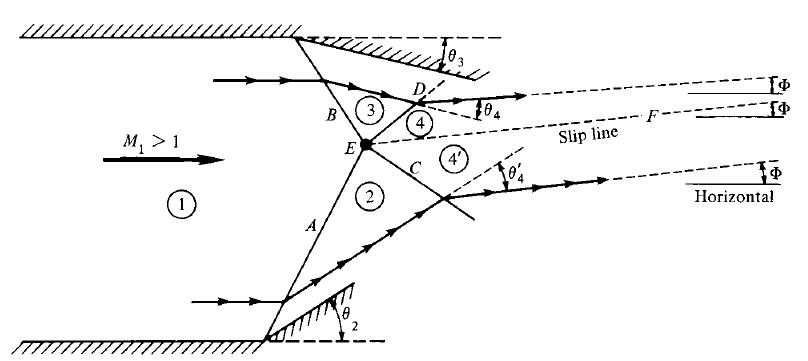
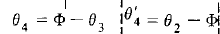

In [16]:
def two_shock_asym_RR_mach_rel(M_1,theta_2,theta_3,p_1=1,rho_1=1,T_1=1,gamma=1.4):
    phi_2,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1 = oblique_shock_downstream_values(M_1,\
                                           theta_2,p_1,rho_1,T_1,gamma=1.4)
    p_2 = p_2_p_1*p_1
    T_2 = T_2_T_1*T_1
    rho_2 = rho_2_rho_1*rho_1
    
    phi_3,M_3,p_3_p_1,rho_3_rho_1,T_3_T_1 = oblique_shock_downstream_values(M_1,\
                                           theta_3,p_1,rho_1,T_1,gamma=1.4)
    p_3 = p_3_p_1*p_1
    T_3 = T_3_T_1*T_1
    rho_3 = rho_3_rho_1*rho_1
    
    def constrain_eqn(V):
        phi_4l   = V[0]
        phi_4u   = V[1]
        PHI      = V[2]
        
        theta_4l = theta_2 - PHI
        theta_4u = PHI - theta_3
        
        F  =  np.zeros(np.shape(V))
        F[0] = theta_phi_rel(phi_4l,M_2,theta_4l,gamma=1.4)
        F[1] = theta_phi_rel(phi_4u,M_3,theta_4u,gamma=1.4)
        p_4l,p_r = downstream_pressure(phi_4l,M_2,p_2,gamma=1.4)
        p_4u,p_r = downstream_pressure(phi_4u,M_3,p_3,gamma=1.4)
        F[2] = p_4u-p_4l
        
        return F
    
    init_guess = np.array([phi_2,phi_3,0],dtype='float64')
    soln = fsolve(constrain_eqn,init_guess)
    
    phi_4l   = soln[0]
    phi_4u   = soln[1]
    PHI      = soln[2]
    
    theta_4l = theta_2 - PHI
    theta_4u = PHI - theta_3
        
    phi,M_4l,p_4l_p_2,rho_4l_rho_2,T_4l_T_2 = oblique_shock_downstream_values(M_2,\
                                           theta_4l,p_2,rho_2,T_2,gamma=1.4)
    p_4l = p_4l_p_2*p_2
    T_4l = T_4l_T_2*T_2
    rho_4l = rho_4l_rho_2*rho_2
    
    phi,M_4u,p_4u_p_3,rho_4u_rho_3,T_4u_T_3 = oblique_shock_downstream_values(M_3,\
                                           theta_4u,p_3,rho_3,T_3,gamma=1.4)
    p_4u = p_4u_p_3*p_3
    T_4u = T_4u_T_3*T_3
    rho_4u = rho_4u_rho_3*rho_3

    phi = np.array([phi_2,phi_3,phi_4l,phi_4u],dtype='float64')
    M   = np.array([M_2,M_3,M_4l,M_4u],dtype='float64')
    p   = np.array([p_2,p_3,p_4l,p_4u],dtype='float64')
    T   = np.array([T_2,T_3,T_4l,T_4u],dtype='float64')
    rho = np.array([rho_2,rho_3,rho_4l,rho_4u],dtype='float64')
    
    return phi,M,p,rho,T

In [17]:
M_1 = 3
theta_1 = np.deg2rad(20)
p_1 = 1000
T_1 = 1
rho_1 = rho_fn(p_1,T_1,R=287)

phi,M,p,rho,T= two_shock_sym_RR_mach_rel(M_1,theta_1,p_0=p_1,rho_0=rho_1,T_0=T_1,gamma=1.4)

# theta_2 = np.deg2rad(20)
# theta_3 = np.deg2rad(10)
# phi,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1= two_shock_asym_RR_mach_rel(M_1,theta_2,theta_3,p_1=p_1,rho_1=rho_1,T_1=T_1,gamma=1.4)
# print(np.rad2deg(phi),M_2,p_2_p_1,rho_2_rho_1,T_2_T_1)

string = "***phi*** = " + str(np.rad2deg(phi))    
printmd(string)
string = "***M_2*** = " + str(M_2)    
printmd(string)
string = "***p_2_p_1*** = " + str(p_2_p_1)    
printmd(string)
string = "***rho_2_rho_1*** = " + str(rho_2_rho_1)      
printmd(string)
string = "***T_2_T_1*** = " + str(T_2_T_1)       
printmd(string)

NameError: name 'rho_fn' is not defined

### Three shock theory

#### Symmetric mach reflections

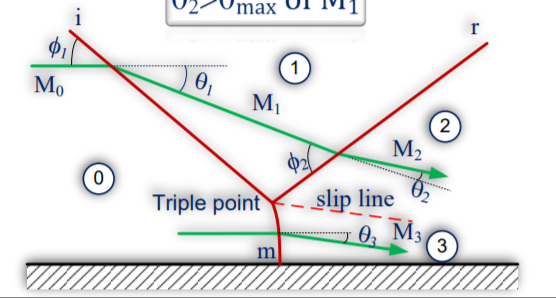

In [ ]:
def three_shock_sym_RR_mach_rel(M_0,theta_1,p_0=1,rho_0=1,T_0=1,gamma=1.4):
    phi_1,M_1,p_1_p_0,rho_1_rho_0,T_1_T_0 = oblique_shock_downstream_values(M_0,\
                                           theta_1,p_0,rho_0,T_0,gamma=1.4)
    p_1 = p_1_p_0*p_0
    T_1 = T_1_T_0*T_0
    rho_1 = rho_1_rho_0*rho_0
    
    def constrain_eqn(V):
        phi_3   = V[0]
        phi_2   = V[1]
        theta_2 = V[2]
        
        theta_3 = theta_1 - theta_2
#         theta_3 = 0
        
        F  =  np.zeros(np.shape(V))
        F[0] = theta_phi_rel(phi_3,M_0,theta_3,gamma=1.4)
        F[1] = theta_phi_rel(phi_2,M_1,theta_2,gamma=1.4)
        p_3,p_r = downstream_pressure(phi_3,M_0,p_0,gamma=1.4)
        p_2,p_r = downstream_pressure(phi_2,M_1,p_1,gamma=1.4)
        F[2] = p_3-p_2
        
        return F
    
    init_guess = np.array([np.deg2rad(90),phi_1,theta_1],dtype='float64')
    soln = fsolve(constrain_eqn,init_guess)
    
    phi_3     = soln[0]
    phi_2     = soln[1]
    theta_2   = soln[2]
    
    theta_3 = theta_1 - theta_2
        
    phi,M_3,p_3_p_0,rho_3_rho_0,T_3_T_0 = oblique_shock_downstream_values(M_0,\
                                           theta_3,p_0,rho_0,T_0,gamma=1.4,strong=True)
    p_3 = p_3_p_0*p_0
    T_3 = T_3_T_0*T_0
    rho_3 = rho_3_rho_0*rho_0
    
    phi,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1 = oblique_shock_downstream_values(M_1,\
                                           theta_2,p_1,rho_1,T_1,gamma=1.4)
    p_2 = p_2_p_1*p_1
    T_2 = T_2_T_1*T_1
    rho_2 = rho_2_rho_1*rho_1
    
    phi = np.array([phi_1,phi_2,phi_3],dtype='float64')
    M   = np.array([M_1,M_2,M_3],dtype='float64')
    p   = np.array([p_1,p_2,p_3],dtype='float64')
    T   = np.array([T_1,T_2,T_3],dtype='float64')
    rho = np.array([rho_1,rho_2,rho_3],dtype='float64')
    theta =  np.array([theta_1,theta_2,theta_3],dtype='float64')

    return phi,M,p,rho,T,theta
    

In [ ]:
M_1 = 5
theta = np.deg2rad(30)
p_1 = 1
T_1 = 1
rho_1 = rho_fn(p_1,T_1,R=287)

phi,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1,theta= three_shock_sym_RR_mach_rel(M_1,theta,p_0=p_1,rho_0=rho_1,T_0=T_1,gamma=1.4)
# print(np.rad2deg(phi),M_2,p_2_p_1,rho_2_rho_1,T_2_T_1)

string = "***phi*** = " + str(np.rad2deg(phi))    
printmd(string)
string = "***M_2*** = " + str(M_2)    
printmd(string)
string = "***p_2_p_1*** = " + str(p_2_p_1)    
printmd(string)
string = "***rho_2_rho_1*** = " + str(rho_2_rho_1)      
printmd(string)
string = "***T_2_T_1*** = " + str(T_2_T_1)       
printmd(string)
string = "***Theta*** = " + str(np.rad2deg(theta))       
printmd(string)
# mach_to_vel(M_2,T_2_T_1,R=287,gamma=1.4)

# np.rad2deg(0.26928579)

#### Antisymmetric mach reflections

## <ins>Conservation equations</ins>

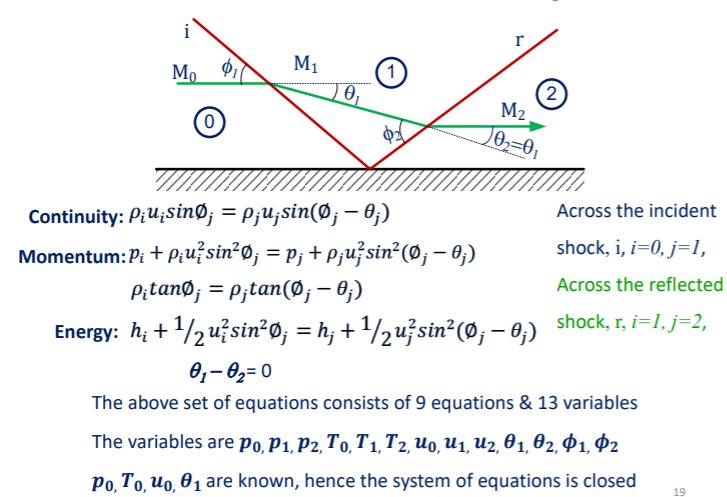

In [ ]:
def rho_fn(p,T,R=287):
        return p/(R*T)
def Temp(h,gamma=1.4,R=287):
    Cp = gamma*R/(gamma-1)
    return h/Cp
def enthalpy(T,gamma=1.4,R=287):
    Cp = gamma*R/(gamma-1)
    return T*Cp
def mach_to_vel(M,T,R=287,gamma=1.4):
    return np.sqrt(gamma*R*T)*M
def vel_to_mach(u,T,R=287,gamma=1.4):
    return u/np.sqrt(gamma*R*T)

### Single shock

In [ ]:
def cons_eqn(DV,p_1,T_1,u_1,theta_2,rho_1):
#     DV => Downstream variables (2)
    phi_2   = DV[0]
    u_2     = DV[1]
    p_2     = DV[2]
    h_2     = DV[3]
    T_2     = Temp(h_2)
    rho_2   = rho_fn(p_2,T_2)


#     rho_1   = rho(p_1,T_1)
    h_1     = enthalpy(T_1)
    
    F  =  np.zeros(np.shape(DV))
    
    F[0]    = rho_2*u_2*np.sin(phi_2-theta_2) - \
              rho_1*u_1*np.sin(phi_2)
    
    F[1]    = (p_2 + rho_2*u_2**2*np.sin(phi_2-theta_2)**2) - \
              (p_1 + rho_1*u_1**2*np.sin(phi_2)**2)
    
    F[2]    = rho_2*np.tan(phi_2-theta_2) - \
              rho_1*np.tan(phi_2)
    
    F[3]    = (h_2 + 0.5*u_2**2*np.sin(phi_2-theta_2)**2) - \
              (h_1 + 0.5*u_1**2*np.sin(phi_2)**2)
            
    
    return F

p_1      = 1
T_1      = 1
rho_1    = rho_fn(p_1,T_1,R=287)
u_1      = mach_to_vel(3,T_1)
theta_2  = np.deg2rad(20)
init_guess = np.array([0.7,50,1,1004])
soln = fsolve(cons_eqn,init_guess,args=(p_1,T_1,u_1,theta_2,rho_1))

phi_2   = soln[0]
u_2     = soln[1]
p_2     = soln[2]
h_2     = soln[3]
T_2     = Temp(h_2)
rho_2   = rho_fn(p_2,T_2)
M_2     = vel_to_mach(u_2,T_2,R=287,gamma=1.4)
print(np.rad2deg(phi_2),M_2,p_2,rho_2/rho_1,T_2)


In [ ]:
# # enthalpy(1,gamma=1.4,R=287)
# # vel_to_mach(soln[1],Temp(soln[3]))
# Temp(soln[3])
# # mach_to_vel(1,Temp(soln[3]))
# mach_to_vel(1.99413167,1.5596173)
# # np.rad2deg(0.85198)

In [ ]:
# # mach_to_vel(2,298)
# DV = np.array([2,2,2,2])
# np.zeros(np.shape(DV))

### Two shock theory (consv)

#### Symmetric Regular reflection

In [ ]:
def two_shock_symm_cons_eqn(M_0,theta_1,p_0=1,rho_0=1,T_0=1,gamma=1.4,
                            init_guess = np.array([0.7,50,1,1004,0.7,0,1,1004])):

    u_0      = mach_to_vel(M_0,T_0)
    h_0     = enthalpy(T_0)
    
    def cons_eqn(DV):
    #     DV => Downstream variables (2)
        phi_1   = DV[0]
        u_1     = DV[1]
        p_1     = DV[2]
        h_1     = DV[3]
        T_1     = Temp(h_1)
        rho_1   = rho_fn(p_1,T_1)

        phi_2   = DV[4]
        u_2     = DV[5]
        p_2     = DV[6]
        h_2     = DV[7]
        T_2     = Temp(h_2)
        rho_2   = rho_fn(p_2,T_2)
        
        theta_2 = theta_1
    
        
        F  =  np.zeros(np.shape(DV))

        F[0]    = rho_1*u_1*np.sin(phi_1-theta_1) - \
                  rho_0*u_0*np.sin(phi_1)

        F[1]    = (p_1 + rho_1*u_1**2*np.sin(phi_1-theta_1)**2) - \
                  (p_0 + rho_0*u_0**2*np.sin(phi_1)**2)

        F[2]    = rho_1*np.tan(phi_1-theta_1) - \
                  rho_0*np.tan(phi_1)

        F[3]    = (h_1 + 0.5*u_1**2*np.sin(phi_1-theta_1)**2) - \
                  (h_0 + 0.5*u_0**2*np.sin(phi_1)**2)
        
        F[4]    = rho_2*u_2*np.sin(phi_2-theta_2) - \
                  rho_1*u_1*np.sin(phi_2)

        F[5]    = (p_2 + rho_2*u_2**2*np.sin(phi_2-theta_2)**2) - \
                  (p_1 + rho_1*u_1**2*np.sin(phi_2)**2)

        F[6]    = rho_2*np.tan(phi_2-theta_2) - \
                  rho_1*np.tan(phi_2)

        F[7]    = (h_2 + 0.5*u_2**2*np.sin(phi_2-theta_2)**2) - \
                  (h_1 + 0.5*u_1**2*np.sin(phi_2)**2)


        return F

#     init_guess = np.array([0.7,50,1,1004,0.7,0,1,1004])
    soln = fsolve(cons_eqn,init_guess)
    
    phi_1  = soln[0]
    u_1    = soln[1]
    p_1    = soln[2]
    h_1    = soln[3]
    T_1    = Temp(h_1)
    rho_1  = rho_fn(p_1,T_1)
    M_1    = vel_to_mach(u_1,T_1,R=287,gamma=1.4)
    
    phi_2   = soln[4]
    u_2     = soln[5]
    p_2     = soln[6]
    h_2     = soln[7]
    T_2     = Temp(h_2)
    rho_2   = rho_fn(p_2,T_2)
    M_2     = vel_to_mach(u_2,T_2,R=287,gamma=1.4)
    
    theta_2 = theta_1
    phi = np.array([phi_1,phi_2],dtype='float64')
    M   = np.array([M_1,M_2],dtype='float64')
    p   = np.array([p_1,p_2],dtype='float64')
    T   = np.array([T_1,T_2],dtype='float64')
    rho = np.array([rho_1,rho_2],dtype='float64')
    theta =  np.array([theta_1,theta_2],dtype='float64')

    return phi,M,p,rho,T,theta

In [ ]:
M_1 = 3
theta = np.deg2rad(20)
p_1 = 1
T_1 = 1
rho_1 = rho_fn(p_1,T_1,R=287)

phi,M,p,rho,T,theta = two_shock_symm_cons_eqn(M_1,theta,p_0=p_1,rho_0=rho_1,T_0=T_1,gamma=1.4)
# print(np.rad2deg(phi),M_2,p_2_p_1,rho_2_rho_1,T_2_T_1)

string = "***phi*** = " + str(np.rad2deg(phi))    
printmd(string)
string = "***M_2*** = " + str(M_2)    
printmd(string)
string = "***p_2_p_1*** = " + str(p_2_p_1)    
printmd(string)
string = "***rho_2_rho_1*** = " + str(rho_2_rho_1)      
printmd(string)
string = "***T_2_T_1*** = " + str(T_2_T_1)       
printmd(string)
string = "***Theta*** = " + str(theta)       
printmd(string)
phi

### Three shock theory (consv)

#### Symmetric Mach reflection

In [ ]:
def three_shock_symm_cons_eqn(M_0,theta_1,p_0=1,rho_0=1,T_0=1,gamma=1.4):

    u_0      = mach_to_vel(M_0,T_0)
    h_0     = enthalpy(T_0)
    
    def cons_eqn(DV):
    #     DV => Downstream variables (2)
        phi_1   = DV[0]
        u_1     = DV[1]
        p_1     = DV[2]
        h_1     = DV[3]
        T_1     = Temp(h_1)
        rho_1   = rho_fn(p_1,T_1)
        M_1     = vel_to_mach(u_1,T_1,R=287,gamma=1.4)

        phi_2   = DV[4]
        u_2     = DV[5]
        p_2     = DV[6]
        h_2     = DV[7]
        theta_2 = DV[8]
        T_2     = Temp(h_2)
        rho_2   = rho_fn(p_2,T_2)
        
        phi_3   = DV[9]
        u_3     = DV[10]
        p_3     = DV[11]
        h_3     = DV[12]
        T_3     = Temp(h_3)
        rho_3   = rho_fn(p_3,T_3)
        
        theta_3 = theta_1 - theta_2
#         print(theta_1,theta_2,theta_3)
        
    
        
        F  =  np.zeros(np.shape(DV))

#         region 0 to region 1
        F[0]    = rho_1*u_1*np.sin(phi_1-theta_1) - \
                  rho_0*u_0*np.sin(phi_1)

        F[1]    = (p_1 + rho_1*u_1**2*np.sin(phi_1-theta_1)**2) - \
                  (p_0 + rho_0*u_0**2*np.sin(phi_1)**2)

        F[2]    = rho_1*np.tan(phi_1-theta_1) - \
                  rho_0*np.tan(phi_1)

        F[3]    = (h_1 + 0.5*u_1**2*np.sin(phi_1-theta_1)**2) - \
                  (h_0 + 0.5*u_0**2*np.sin(phi_1)**2)
        
#         region 1 to region 2
        F[4]    = rho_2*u_2*np.sin(phi_2-theta_2) - \
                  rho_1*u_1*np.sin(phi_2)

        F[5]    = (p_2 + rho_2*u_2**2*np.sin(phi_2-theta_2)**2) - \
                  (p_1 + rho_1*u_1**2*np.sin(phi_2)**2)

        F[6]    = rho_2*np.tan(phi_2-theta_2) - \
                  rho_1*np.tan(phi_2)
        
        F[7]    = (h_2 + 0.5*u_2**2*np.sin(phi_2-theta_2)**2) - \
                  (h_1 + 0.5*u_1**2*np.sin(phi_2)**2)
        
#         region 0 to region 3
        F[8]    = rho_3*u_3*np.sin(phi_3-theta_3) - \
                  rho_0*u_0*np.sin(phi_3)

        F[9]    = (p_3 + rho_3*u_3**2*np.sin(phi_3-theta_3)**2) - \
                  (p_0 + rho_0*u_0**2*np.sin(phi_3)**2)

        F[10]   = rho_3*np.tan(phi_3-theta_3) - \
                  rho_0*np.tan(phi_3)

        F[11]   = (h_3 + 0.5*u_3**2*np.sin(phi_3-theta_3)**2) - \
                  (h_0 + 0.5*u_0**2*np.sin(phi_3)**2)
        
        p_3,p_r = downstream_pressure(phi_3,M_0,p_0,gamma=1.4)
        p_2,p_r = downstream_pressure(phi_2,M_1,p_1,gamma=1.4)
        F[12]   = p_3-p_2
    

        return F

    init_guess = np.array([1.13,35,8,2004,1.08,30,10,2004,0.08,1.19,30,8,2004])
    soln = fsolve(cons_eqn,init_guess)

    phi_1  = soln[0]
    u_1    = soln[1]
    p_1    = soln[2]
    h_1    = soln[3]
    T_1    = Temp(h_1)
    rho_1  = rho_fn(p_1,T_1)
    M_1    = vel_to_mach(u_1,T_1,R=287,gamma=1.4)
    
    phi_2   = soln[4]
    u_2     = soln[5]
    p_2     = soln[6]
    h_2     = soln[7]
    theta_3 = soln[8]
    T_2     = Temp(h_2)
    rho_2   = rho_fn(p_2,T_2)
    M_2     = vel_to_mach(u_2,T_2,R=287,gamma=1.4)
    
    phi_3   = soln[9]
    u_3     = soln[10]
    p_3     = soln[11]
    h_3     = soln[12]
    T_3     = Temp(h_3)
    rho_3   = rho_fn(p_3,T_3)
    M_3     = vel_to_mach(u_3,T_3,R=287,gamma=1.4)
    
    
    phi = np.array([phi_1,phi_2,phi_3],dtype='float64')
    M   = np.array([M_1,M_2,M_3],dtype='float64')
    p   = np.array([p_1,p_2,p_3],dtype='float64')
    T   = np.array([T_1,T_2,T_3],dtype='float64')
    rho = np.array([rho_1,rho_2,rho_3],dtype='float64')
    theta =  np.array([theta_1,theta_2,theta_3],dtype='float64')

    return phi,M,p,rho,T,theta

In [ ]:
M_1 = 3
theta = np.deg2rad(40)
p_1 = 1
T_1 = 1
rho_1 = rho(p_1,T_1,R=287)

phi,M_2,p_2_p_1,rho_2_rho_1,T_2_T_1,theta= three_shock_symm_cons_eqn(M_1,theta,p_0=p_1,rho_0=rho_1,T_0=T_1,gamma=1.4)
# print(np.rad2deg(phi),M_2,p_2_p_1,rho_2_rho_1,T_2_T_1)

string = "***phi*** = " + str(np.rad2deg(phi))    
printmd(string)
string = "***M_2*** = " + str(M_2)    
printmd(string)
string = "***p_2_p_1*** = " + str(p_2_p_1)    
printmd(string)
string = "***rho_2_rho_1*** = " + str(rho_2_rho_1)      
printmd(string)
string = "***T_2_T_1*** = " + str(T_2_T_1)       
printmd(string)
string = "***Theta*** = " + str(theta)       
printmd(string)

## <ins>Shock polar</ins>

In [ ]:
class polar_cls:
    def __init__(self,theta,y):
        self.theta = theta
        self.y     = y
    def value(self,theta_n):
        f = interpolate.interp1d(self.theta,self.y,axis=0,bounds_error=False,fill_value=0)
        return f(theta_n)
    def update(self,theta_n,y_n):
        self.theta = theta_n
        self.y     = y_n
        

In [ ]:
x = np.arange(0, 10)
y = np.zeros([len(x),2])
y[:,0] = np.exp(-x/3.0)
polar_r1 = polar_cls(x,y)


xnew = np.arange(-10, 20, 0.1)
ynew = polar_r1.value(xnew) # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

# polar_r1.update(x,y*2)

# x[:-1]


### single polar

In [ ]:
def shock_polar(M,no_points=50,theta_start=0.01,gamma=1.4,theta_seed_no=10):
#     """the solution doesn't converge at exactly theta_max, 
#     so need to decrease theta limit (end_corr)"""
    
    theta     = np.zeros([2*no_points+1,len(M)])
    phi       = np.zeros([2*no_points+1,len(M)])
    p_ratio   = np.zeros([2*no_points+1,len(M)])
    rho_ratio = np.zeros([2*no_points+1,len(M)])
    T_ratio   = np.zeros([2*no_points+1,len(M)])
    M_2       = np.zeros([2*no_points+1,len(M)])
    
     # find theta max for M
    for M_No in range(len(M)):
        theta_max,phi_theta_max   = theta_phi_limits(np.array([M[M_No]]),gamma=1.4)
        theta_l = np.linspace(np.zeros(np.shape(theta_max))+theta_start,
                                   theta_max-0.001,no_points)
        theta_l = theta_l.reshape(theta_l.shape[0])

        # need to loop over each theta and find both the soltions
        phi_l = np.zeros([no_points,2])
        for thetaNo in range(no_points):
            stop = False
            while stop!=True:
            
                theta_seed = theta_l[thetaNo] + (np.pi/2 - theta_l[thetaNo])\
                            *np.random.rand(theta_seed_no) # change the range to [theta,pi/2]

                phi_res    = wave_angle(theta_l[thetaNo],M[M_No],
                               phi_init=theta_seed,gamma=1.4) # phi or beta

                phi_res = np.unique(np.round(phi_res,4))
                ind= phi_res<np.pi/2

                if sum(ind)<=2: 
                    phi_l[thetaNo,:] = phi_res[ind]
                    stop=True
#                 else:
#                     print(ind,phi_res)
                


        theta_l = np.concatenate((theta_l,theta_max))
        theta_l = np.concatenate((theta_l,np.flip(theta_l[:-1])))

        phi_lo    = np.concatenate((phi_l[:,0],phi_theta_max)) 
        phi_up    = phi_l[:,1]
        phi_l     = np.concatenate((phi_lo,np.flip(phi_up)))
        phi_l[-1] = np.pi/2
        
        theta[:,M_No] = theta_l
        phi[:,M_No]   = phi_l
        
        _,p_ratio[:,M_No]   = downstream_pressure(phi[:,M_No],M[M_No],p_1=1.0,gamma=1.4)
        _,rho_ratio[:,M_No] = downstream_density(phi[:,M_No],M[M_No],rho_1=1,gamma=1.4)
        _,T_ratio[:,M_No]   = downstream_temperature(phi[:,M_No],M[M_No],T_1=1,gamma=1.4)
        M_2[:,M_No]         = downstream_mach_no(phi[:,M_No],theta[:,M_No],M[M_No],gamma=1.4)

        
    return theta,phi,M_2,p_ratio,rho_ratio,T_ratio
    

In [ ]:
def shock_polar_bisect(M,no_points=50,theta_start=0.01,gamma=1.4):
#     """the solution doesn't converge at exactly theta_max, 
#     so need to decrease theta limit (end_corr)"""
    
    theta     = np.zeros([2*no_points+1,len(M)])
    phi       = np.zeros([2*no_points+1,len(M)])
    p_ratio   = np.zeros([2*no_points+1,len(M)])
    rho_ratio = np.zeros([2*no_points+1,len(M)])
    T_ratio   = np.zeros([2*no_points+1,len(M)])
    M_2       = np.zeros([2*no_points+1,len(M)])
    
     # find theta max for M
    for M_No in range(len(M)):
        theta_max,phi_theta_max,_,_   = theta_phi_limits(np.array([M[M_No]]),gamma=1.4)
        theta_l = np.linspace(np.zeros(np.shape(theta_max))+theta_start,
                                   theta_max-0.001,no_points)
        theta_l = theta_l.reshape(theta_l.shape[0])

        # need to loop over each theta and find both the soltions
        phi_l = np.zeros([no_points,2])
        for thetaNo in range(no_points):
            
            bnd = np.array([theta_start,phi_theta_max])
            phi_res    = wave_angle_bisect(theta_l[thetaNo],M[M_No],
                               bnd,gamma=1.4) # phi or beta
            phi_l[thetaNo,0] = phi_res
            
            bnd = np.array([phi_theta_max,np.deg2rad(95)])
            phi_res    = wave_angle_bisect(theta_l[thetaNo],M[M_No],
                               bnd,gamma=1.4) # phi or beta
            phi_l[thetaNo,1] = phi_res
                

         
        
        theta_l = np.concatenate((theta_l,theta_max))
        x_obj   = np.concatenate((-np.flip(theta_l),theta_l))
        theta_l = np.concatenate((theta_l,np.flip(theta_l[:-1])))

        phi_lo    = np.concatenate((phi_l[:,0],phi_theta_max))         
        phi_up    = phi_l[:,1]
        phi_l     = np.concatenate((phi_lo,np.flip(phi_up)))
        phi_l[-1] = np.pi/2
        
        y_obj         = np.zeros([2*(no_points+1),2])        
        y_up          = np.concatenate((phi_up,phi_theta_max))
        
        y_obj[:,0]    = np.concatenate((np.flip(phi_lo),phi_lo))
        y_obj[:,1]    = np.concatenate((np.flip(y_up),y_up))
        
        theta[:,M_No] = theta_l
        phi[:,M_No]   = phi_l
        
        _,p_ratio[:,M_No]   = downstream_pressure(phi[:,M_No],M[M_No],p_1=1.0,gamma=1.4)
        _,rho_ratio[:,M_No] = downstream_density(phi[:,M_No],M[M_No],rho_1=1,gamma=1.4)
        _,T_ratio[:,M_No]   = downstream_temperature(phi[:,M_No],M[M_No],T_1=1,gamma=1.4)
        M_2[:,M_No]         = downstream_mach_no(phi[:,M_No],theta[:,M_No],M[M_No],gamma=1.4)
        
        _,y_obj[:,0]   = downstream_pressure(y_obj[:,0],M[M_No],p_1=1.0,gamma=1.4)
        _,y_obj[:,1]   = downstream_pressure(y_obj[:,1],M[M_No],p_1=1.0,gamma=1.4)
        
        polar_obj = polar_cls(x_obj,y_obj)

        
    return theta,phi,M_2,p_ratio,rho_ratio,T_ratio,polar_obj
    

### shock polar solution for symmetric reflections

In [45]:
def shock_polar_symm_refl(M_0,theta_1,no_points=50,theta_start=0.01,gamma=1.4):
    
    phi_1,M_1,p_ratio_1,rho_ratio_1,T_ratio_1 \
        = oblique_shock_downstream_values(M_0,theta_1,p_1=1,rho_1=1,T_1=1,gamma=1.4)
    
    theta_M_1,phi_M_1,M_2,p_ratio_M_1,rho_ratio_M_1,T_ratio_M_1,p_obj_1 \
        = shock_polar_bisect(M_0,no_points,theta_start,gamma)
    
    theta_M_2,phi_M_2,M_3,p_ratio_M_2,rho_ratio_M_2,T_ratio_M_2,p_obj_2 \
        = shock_polar_bisect(M_1,no_points,theta_start,gamma)
    
        
    theta_M_2     += theta_1
    phi_M_2       += phi_1
#     p_ratio_M_2   += p_ratio_1-1
    rho_ratio_M_2 += rho_ratio_1-1
    T_ratio_M_2   += T_ratio_1-1
    
    p_ratio_M_2   = (p_ratio_M_2-1)*p_ratio_1  + p_ratio_1 
    
#     print(M_1)
#     plt.plot(theta_M_1,p_ratio_M_1,'b',-theta_M_1,p_ratio_M_1,'b')
#     plt.plot(theta_M_2,p_ratio_M_2,'r',-theta_M_2+2*theta_1,p_ratio_M_2,'r')
#     plt.axvline(theta_1,linestyle = '--')
#     plt.axvline(x=0, color='k',linestyle = '--')
    
    
    plt.style.use('seaborn-white')
    %matplotlib inline

    plt.rcParams.update({'font.size': 26})

    fig, ax = plt.subplots()
    fig.set_size_inches(12.5, 8.5, forward=True)
    ax.plot(np.rad2deg(theta_M_1),p_ratio_M_1,'b',np.rad2deg(-theta_M_1),p_ratio_M_1,'b',linewidth=4)
    ax.plot(np.rad2deg(theta_M_2),p_ratio_M_2,'r',np.rad2deg(-theta_M_2+2*theta_1),p_ratio_M_2,'r',linewidth=4)
    ax.set(xlabel='$\\theta$', ylabel='$p_j/p_i$',title='')
    ax.axvline(np.rad2deg(theta_1),linestyle = '--')
    ax.axvline(x=0, color='k',linestyle = '--')
    ax.grid()
    return fig
#     leg = ax.legend()


### shock polar solution for asymmetric reflections

In [59]:
def shock_polar_asymm_refl(M_0,theta_1,theta_2,plot=False,no_points=50,theta_start=0.01,gamma=1.4):
    
    phi_1,M_1,p_ratio_1,rho_ratio_1,T_ratio_1 \
        = oblique_shock_downstream_values(M_0,theta_1,p_1=1,rho_1=1,T_1=1,gamma=1.4)
    
    phi_2,M_2,p_ratio_2,rho_ratio_2,T_ratio_2 \
        = oblique_shock_downstream_values(M_0,theta_2,p_1=1,rho_1=1,T_1=1,gamma=1.4)
        
        
        
    theta_M_0,phi_M_0,M_2_M_0,p_ratio_M_0,rho_ratio_M_0,T_ratio_M_0,p_obj_0 \
        = shock_polar_bisect(M_0,no_points,theta_start,gamma)
    
    theta_M_1,phi_M_1,M_3l,p_ratio_M_1,rho_ratio_M_1,T_ratio_M_1,p_obj_1 \
        = shock_polar_bisect(M_1,no_points,theta_start,gamma)
    
    theta_M_2,phi_M_2,M_3u,p_ratio_M_2,rho_ratio_M_2,T_ratio_M_2,p_obj_2 \
        = shock_polar_bisect(M_2,no_points,theta_start,gamma)
    
        
    theta_M_1     += theta_1
    theta_M_2     += theta_2
    
    p_obj_1.update(p_obj_1.theta+theta_1,(p_obj_1.y-1)*p_ratio_1 + p_ratio_1)
    p_obj_2.update(p_obj_2.theta-theta_2,(p_obj_2.y-1)*p_ratio_2 + p_ratio_2)
#     phi_M_2       += phi_1
#     rho_ratio_M_2 += rho_ratio_1-1
#     T_ratio_M_2   += T_ratio_1-1
    
    p_ratio_M_1   = (p_ratio_M_1-1)*p_ratio_1  + p_ratio_1 
    p_ratio_M_2   = (p_ratio_M_2-1)*p_ratio_2  + p_ratio_2 
    
    T_ratio_M_1   = (T_ratio_M_1-1)*T_ratio_1  + T_ratio_1 
    T_ratio_M_2   = (T_ratio_M_2-1)*T_ratio_2  + T_ratio_2 
    
    rho_ratio_M_1   = (rho_ratio_M_1-1)*rho_ratio_1  + rho_ratio_1 
    rho_ratio_M_2   = (rho_ratio_M_2-1)*rho_ratio_2  + rho_ratio_2 
    
    
    
    
    
    
    
#     print(M_1,M_2)
    if plot==True:
        
        plt.style.use('seaborn-white')
#         %matplotlib inline
        %matplotlib widget

        plt.rcParams.update({'font.size': 26})

        fig1, ax = plt.subplots()
#         fig1.set_size_inches(12.5, 8.5, forward=True)
        ax.plot(np.rad2deg(theta_M_0),p_ratio_M_0,'b',-np.rad2deg(theta_M_0),p_ratio_M_0,'b',linewidth=1)
        ax.plot(np.rad2deg(theta_M_1),p_ratio_M_1,'g', np.rad2deg(-theta_M_1+2*theta_1),p_ratio_M_1,'g',linewidth=1)
        ax.plot(-np.rad2deg(theta_M_2),p_ratio_M_2,'r',np.rad2deg(theta_M_2-2*theta_2),p_ratio_M_2,'r',linewidth=1)
#         ax.plot(np.rad2deg(theta_M_1),p_ratio_M_1,'b',np.rad2deg(-theta_M_1),p_ratio_M_1,'b',linewidth=4)
#         ax.plot(np.rad2deg(theta_M_2),p_ratio_M_2,'r',np.rad2deg(-theta_M_2+2*theta_1),p_ratio_M_2,'r',linewidth=4)
        ax.set(xlabel='$\\theta$', ylabel='$p_j/p_i$',title='')
        ax.axvline( np.rad2deg(theta_1),linestyle = '--')
        ax.axvline(-np.rad2deg(theta_2),linestyle = '--')
        ax.axvline(x=0, color='k',linestyle = '--')
        ax.grid()
        
#         fig2, ax = plt.subplots()
#         fig2.set_size_inches(12.5, 8.5, forward=True)
#         ax.plot(np.rad2deg(theta_M_0),T_ratio_M_0,'b',-np.rad2deg(theta_M_0),T_ratio_M_0,'b',linewidth=4)
#         ax.plot(np.rad2deg(theta_M_1),T_ratio_M_1,'g', np.rad2deg(-theta_M_1+2*theta_1),T_ratio_M_1,'g',linewidth=4)
#         ax.plot(-np.rad2deg(theta_M_2),T_ratio_M_2,'r',np.rad2deg(theta_M_2-2*theta_2),T_ratio_M_2,'r',linewidth=4)
# #         ax.plot(np.rad2deg(theta_M_1),p_ratio_M_1,'b',np.rad2deg(-theta_M_1),p_ratio_M_1,'b',linewidth=4)
# #         ax.plot(np.rad2deg(theta_M_2),p_ratio_M_2,'r',np.rad2deg(-theta_M_2+2*theta_1),p_ratio_M_2,'r',linewidth=4)
#         ax.set(xlabel='$\\theta$', ylabel='$T_j/T_i$',title='')
#         ax.axvline( np.rad2deg(theta_1),linestyle = '--')
#         ax.axvline(-np.rad2deg(theta_2),linestyle = '--')
#         ax.axvline(x=0, color='k',linestyle = '--')
#         ax.grid()
        
#         fig3, ax = plt.subplots()
#         fig3.set_size_inches(12.5, 8.5, forward=True)
#         ax.plot(np.rad2deg(theta_M_0),M_2_M_0,'b',-np.rad2deg(theta_M_0),M_2_M_0,'b',linewidth=4)
#         ax.plot(np.rad2deg(theta_M_1),M_3l,'g', np.rad2deg(-theta_M_1+2*theta_1),M_3l,'g',linewidth=4)
#         ax.plot(-np.rad2deg(theta_M_2),M_3u,'r',np.rad2deg(theta_M_2-2*theta_2),M_3u,'r',linewidth=4)
# #         ax.plot(np.rad2deg(theta_M_1),p_ratio_M_1,'b',np.rad2deg(-theta_M_1),p_ratio_M_1,'b',linewidth=4)
# #         ax.plot(np.rad2deg(theta_M_2),p_ratio_M_2,'r',np.rad2deg(-theta_M_2+2*theta_1),p_ratio_M_2,'r',linewidth=4)
#         ax.set(xlabel='$\\theta$', ylabel='$T_j/T_i$',title='')
#         ax.axvline( np.rad2deg(theta_1),linestyle = '--')
#         ax.axvline(-np.rad2deg(theta_2),linestyle = '--')
#         ax.axvline(x=0, color='k',linestyle = '--')
#         ax.grid()
    
    
    
#     idx = np.argwhere(np.diff(np.sign(p_ratio_M_1 - p_ratio_M_2))).flatten()
#     print(p_ratio_M_1 - p_ratio_M_2)
#     plt.plot(x[idx], f[idx], 'ro')
#     plt.axhline(y=0, color='k')
   
    
    return p_obj_0,p_obj_1,p_obj_2,fig1

### dual domain soln

In [ ]:
def asym_dual_domain_solver(M,no_p = 50,no_pw2=100,tan_err_x=1e-3,tan_err_y=1e-3,root_err=1e-4,gamma=1.4):
    
    theta_max,phi_theta_max,_,_   = theta_phi_limits(M,gamma=1.4)
#     theta_w1 = np.linspace(0,theta_max,no_p)
    theta_w1 = np.array([np.deg2rad(25)])
#     theta_w2 = np.linspace(0,theta_max,no_pw2)
    theta_w2 = np.array([np.deg2rad(15)])

    for tw1No in range(no_p):
        for tw2No in range(no_pw2):
            p_obj_0,p_obj_1,p_obj_2 = shock_polar_asymm_refl(M,theta_w1[tw1No],theta_w2[tw2No], \
                                    no_points=100,theta_start=0,gamma=1.4)
            roots_x,roots_y = find_2_polar_root(p_obj_1,p_obj_2,root_err=root_err)
            print(roots_x,np.squeeze(roots_y))
            roots_y = np.squeeze(roots_y)
            if np.abs(roots_x[0]-roots_x[1])<=tan_err_x and np.abs(roots_y[0]-roots_y[1])<=tan_err_y:
                print('root found')
# @jit(nop)        
def find_2_polar_root(p_obj_1,p_obj_2,root_err,no_p=4000):
    ll = min(p_obj_2.theta)
    ul = max(p_obj_1.theta)
    theta = np.linspace(ll,ul,no_p)
    
    a = p_obj_1.value(theta)
    b = p_obj_2.value(theta)
    
    d1 = np.abs(a[:,0] - b[:,0])
    d2 = np.abs(a[:,0] - b[:,1])
    d3 = np.abs(a[:,1] - b[:,0])
    d4 = np.abs(a[:,1] - b[:,1])
    
    ind1 = np.where(d1<root_err)
    ind2 = np.where(d2<root_err)
    ind3 = np.where(d3<root_err)
    ind4 = np.where(d4<root_err)
    
    print(min(d1),min(d2),min(d3),min(d4))
    
    roots_x = np.empty([1])
    roots_y = np.empty([1])
    
    if np.size(ind1)!=0:  roots_x = np.array(theta[ind1])
    if np.size(ind2)!=0:  roots_x = np.concatenate((roots_x,theta[ind2]))
    if np.size(ind3)!=0:  roots_x = np.concatenate((roots_x,theta[ind3]))
    if np.size(ind4)!=0:  roots_x = np.concatenate((roots_x,theta[ind4]))
    
    if np.size(ind1)!=0:  roots_y = np.array((a[ind1,0][0]))
    if np.size(ind2)!=0:  roots_y = np.concatenate((roots_y,a[ind2,0][0]))
    if np.size(ind3)!=0:  roots_y = np.concatenate((roots_y,a[ind3,1][0]))
    if np.size(ind4)!=0:  roots_y = np.concatenate((roots_y,a[ind4,1][0]))
        
    return roots_x,roots_y

In [53]:
M = np.array([5])
s = time.time()
asym_dual_domain_solver(M,no_p = 1,no_pw2=1,tan_err_x=1e-3,tan_err_y=1,root_err=0.066,gamma=1.4)
print(time.time()-s)
# M[0]

NameError: name 'asym_dual_domain_solver' is not defined

In [ ]:
a = np.array([[1,2],[3,4]])
np.shape(a)
ind = np.array([])
np.shape(a[ind,1])
# a[ind,1][0]

In [33]:
M = np.array([5])
theta_1 = np.deg2rad(30)
theta_2 = np.deg2rad(15)
# phi_1 = np.deg2rad(50.01)
# theta_1 = flow_deflection_angle(phi_1,M,gamma=1.4)
plt.style.use('seaborn-white')
%matplotlib widget


# M = np.linspace(3,5,5)
# theta,phi,M_2,p_ratio,rho_ratio,T_ratio = shock_polar(M,no_points=100,theta_start=0,gamma=1.4,theta_seed_no=30)
# theta,phi,M_2,p_ratio,rho_ratio,T_ratio = shock_polar_bisect(M,no_points=100,theta_start=0,gamma=1.4)
shock_polar_symm_refl(M,theta_1,no_points=200,theta_start=0.0001,gamma=1.4)
# p_obj_0,p_obj_1,p_obj_2 = shock_polar_asymm_refl(M,theta_1,theta_2,plot=True,no_points=500,theta_start=0,gamma=1.4)
plt.ylabel('P1/P0')
plt.xlabel('theta')
plt.grid()
# [27.76973316] [27.68972615] [20.86215385]
np.deg2rad(4.3)


NameError: name 'shock_polar_symm_refl' is not defined

In [ ]:
plt.style.use('seaborn-white')
%matplotlib widget
theta = np.linspace(-np.pi/10,np.pi/10,1000)
theta_deg = np.rad2deg(theta)
plt.plot(theta_deg,p_obj_0.value(theta),theta_deg,p_obj_1.value(theta),theta_deg,p_obj_2.value(theta))
plt.show()

In [ ]:
# plt.figure(1, figsize=(6,4))
fig, axs = plt.subplots(2, 2,figsize=(12,8))
axs[0, 0].plot(theta,M_2,-theta,M_2)
axs[0, 0].set_title("Theta-beta")
axs[0, 1].plot(theta,p_ratio,-theta,p_ratio)
axs[0, 1].set_title("p_ratio")
axs[1, 0].plot(theta,rho_ratio,-theta,rho_ratio)
axs[1, 0].set_title('rho_ratio')
axs[1, 1].plot(theta,T_ratio,-theta,T_ratio)
axs[1, 1].set_title('T_ratio')

## RR to MR transition

### Detachment Criteria

In [18]:
def detachment_crit(M,gamma=1.4):
    
    def constrain_eqn(theta_1):
        phi_1 = wave_angle(theta_1,M) # phi or beta 
        M_1   = downstream_mach_no(phi_1,theta_1,M,gamma)
        theta_max,_,theta_sonic,_ = theta_phi_limits(M_1,gamma)
#         print(np.rad2deg(theta_max),np.rad2deg(theta_sonic),M_1,np.rad2deg(theta_1))
        
        F = theta_max-theta_1
        return F
    theta_guess = np.zeros(np.shape(M))
    
    theta_max_trans = fsolve(constrain_eqn,theta_guess)
#     theta_max,_,_,_ = theta_phi_limits(M,gamma)
    return theta_max_trans

### Sonic Criteria

In [19]:
def sonic_crit(M,gamma=1.4):
    def constrain_eqn(theta_1):
        phi_1 = wave_angle(theta_1,M) # phi or beta 
        M_1   = downstream_mach_no(phi_1,theta_1,M,gamma)
        theta_max,_,theta_sonic,_ = theta_phi_limits(M_1,gamma)
#         print(np.rad2deg(theta_max),np.rad2deg(theta_sonic),M_1,np.rad2deg(theta_1))
        
        F = theta_sonic-theta_1
        return F
    theta_guess = np.zeros(np.shape(M))
    theta_sonic_trans = fsolve(constrain_eqn,theta_guess)
    return theta_sonic_trans

### Von-neumann criteria

In [20]:
def von_neu_crit(M,gamma=1.4):
    
    def constrain_eqn(V):
#         print(np.shape(V))
        theta_1 = V[0]
        phi_3   = V[1]
#         phi_3 = np.pi/2
        phi_2   = V[2]
        theta_2 = theta_1
        theta_3 = 0
        
        phi_1     = wave_angle(theta_1,M_0)
        M_1       = downstream_mach_no(phi_1,theta_1,M_0,gamma)
        _,p_1_p_0 = downstream_pressure(phi_1,M_0,1,gamma)
    
        F  =  np.zeros(np.shape(V))
        F[0] = theta_phi_rel(phi_3,M_0,theta_3,gamma=1.4)
        F[1] = theta_phi_rel(phi_2,M_1,theta_2,gamma=1.4)
        _,p_3_p_0 = downstream_pressure(phi_3,M_0,1,gamma=1.4)
        _,p_2_p_1 = downstream_pressure(phi_2,M_1,1,gamma=1.4)
        F[2] = p_3_p_0-p_2_p_1*p_1_p_0
        
#         print(F)
        
    
        return F
    
    theta_vn_crit = np.zeros(np.shape(M))
    for MachNo in range(np.size(M)):
        M_0 = M[MachNo]
        init_guess = np.array([0.35,np.pi/2,1],dtype='float64')
        soln = fsolve(constrain_eqn,init_guess)
        theta_vn_crit[MachNo] = soln[0]
    
    return theta_vn_crit
    

In [22]:
M = np.linspace(2.2,5,20)
# M = np.array([5])
theta_d_crit  = detachment_crit(M,gamma=1.4)
theta_s_crit  = sonic_crit(M,gamma=1.4)
theta_vn_crit = von_neu_crit(M,gamma=1.4)
# %matplotlib inline
# plt.plot(M,np.rad2deg(theta_d_crit),M,np.rad2deg(theta_s_crit),'--',M,np.rad2deg(theta_vn_crit),'.-')
# plt.style.use('seaborn-white')
# plt.show()


F:\Anaconda3\anaconda\envs\numcomp\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [32]:
plt.style.use('seaborn-white')
%matplotlib widget

plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots()
fig.set_size_inches(12.5,8.5,forward=True)
ax.plot(M,np.rad2deg(theta_d_crit),'b',label='Detachment criteria',linewidth=4)
ax.plot(M,np.rad2deg(theta_s_crit),'r--',label = 'Sonic criteria',linewidth=4)
ax.plot(M,np.rad2deg(theta_vn_crit),'g-.',label = 'von-Nuemann criteria',linewidth=4)

ax.set(xlabel='M', ylabel='$\\theta$',title='')
ax.grid()
ax.text(4,23,'Dual solution domain')
leg = ax.legend()
fig.savefig("test.png",transparent=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
v = np.array([[1,2,3]])
b = np.ones([10,3])
v*b
np.size(b)

# Expansion fan

## Prandtl meyer function

In [65]:
def prandtl_meyer_func(M,gamma=1.4):
    g_p1 = gamma+1
    g_m1 = gamma-1
    
    f = (g_p1/g_m1)**0.5*np.arctan((g_m1*(M**2-1)/g_p1)**0.5)\
        - np.arctan((M**2-1)**0.5)
    return f

In [64]:
def inv_prandtl_meyer_func(theta,gamma=1.4):
    def constraint_eqn(M):
        return theta-prandtl_meyer_func(M,gamma)
    M_init = 1.5
    res=fsolve(constraint_eqn,M_init)
    return res

## Isoentropic relations

### pressure

In [63]:
def iso_entropic_pressure_rel(M_1,M_2,gamma=1.4):
    p2_p1 = ((2+(gamma-1)*M_1**2)/(2+(gamma-1)*M_2**2))**\
            (gamma/(gamma-1))
    return p2_p1
    

## Expansion fan pressure plots

### Expansion fan pressure plot

In [62]:
def expan_fan_pressure_plot(M,no_points=50,gamma=1.4):
    nu_M1    = prandtl_meyer_func(M,gamma=gamma)
    nu_max = 0.5*np.pi*(np.sqrt((gamma+1)/(gamma-1)) -1)
    theta_max = nu_max - nu_M1 - 0.05
#     print(np.rad2deg(theta_max))
    
    theta = np.linspace(0,theta_max,no_points)
    # find M2
    p2p1 = np.zeros(no_points)
    M_2 = np.zeros(no_points)
    for i in range(no_points):
        nu_M2    = nu_M1 + theta[i]
        M2       = inv_prandtl_meyer_func(nu_M2,gamma=gamma)
        p2p1[i]  = iso_entropic_pressure_rel(M,M2,gamma=gamma)
        M_2[i]   = M2
        
    return theta,p2p1,M_2
        

# Diamond airfoil

## Shock polar solutions

In [25]:
def shock_polar_diamond_airfoil(M_0,foil_w_ang,AoA,plot=False,no_points=50,theta_start=0.01,gamma=1.4): 
    theta_1u = foil_w_ang - AoA
    theta_1l = foil_w_ang + AoA
    
    
    theta_M_0,phi_M_0,M_2_M_0,p_ratio_M_0,rho_ratio_M_0,T_ratio_M_0,p_obj_0 \
        = shock_polar_bisect(M_0,no_points,theta_start,gamma)
    
    ## upper part
    phi_1u,M_1u,p_ratio_1u,rho_ratio_1u,T_ratio_1u \
        = oblique_shock_downstream_values(M_0,theta_1u,p_1=1,rho_1=1,T_1=1,gamma=1.4)
    
    theta_2u = 2*foil_w_ang
    nu_M1u      = prandtl_meyer_func(M_1u,gamma=gamma)
    nu_M2u      = nu_M1u + theta_2u
    M_2u        = inv_prandtl_meyer_func(nu_M2u,gamma=gamma)
    
    theta_2u_range,p_ratio_2u,_ = expan_fan_pressure_plot(M_1u,no_points=50,gamma=1.4)
    p_ratio_2u_val  = iso_entropic_pressure_rel(M_1u,M_2u,gamma=1.4)
    
    theta_3u_range,phi_3u,M_3u,p_ratio_3u,rho_ratio_3u,T_ratio_3u,p_obj_3u \
        = shock_polar_bisect(M_2u,no_points,theta_start,gamma)
    
    p_ratio_2u   = p_ratio_2u*p_ratio_1u
    p_ratio_3u   = p_ratio_3u*p_ratio_2u_val*p_ratio_1u
    
    theta_2u_range = -theta_2u_range + theta_1u
#     theta_3u_range += theta_1u - theta_2u
    
    ## lower part
    phi_1l,M_1l,p_ratio_1l,rho_ratio_1l,T_ratio_1l \
        = oblique_shock_downstream_values(M_0,theta_1l,p_1=1,rho_1=1,T_1=1,gamma=1.4)
    
    theta_2l = 2*foil_w_ang
    nu_M1l      = prandtl_meyer_func(M_1l,gamma=gamma)
    nu_M2l      = nu_M1l + theta_2l
    M_2l        = inv_prandtl_meyer_func(nu_M2l,gamma=gamma)
    
    theta_2l_range,p_ratio_2l,_ = expan_fan_pressure_plot(M_1l,no_points=50,gamma=1.4)
    p_ratio_2l_val  = iso_entropic_pressure_rel(M_1l,M_2l,gamma=1.4)
    
    theta_3l_range,phi_3l,M_3l,p_ratio_3l,rho_ratio_3l,T_ratio_3l,p_obj_3l \
        = shock_polar_bisect(M_2l,no_points,theta_start,gamma)
    
    p_ratio_2l   = p_ratio_2l*p_ratio_1l
    p_ratio_3l   = p_ratio_3l*p_ratio_2l_val*p_ratio_1l
    
    theta_2l_range = theta_2l_range - theta_1l
#     theta_3u_range += theta_1u - theta_2u
    
#     print(M_1,M_2)
    if plot==True:
        
#         plt.style.use('seaborn-white')
#         %matplotlib inline
#         %matplotlib widget

        plt.rcParams.update({'font.size': 24})

        fig1, ax = plt.subplots()
        fig1.set_size_inches(10, 6.67, forward=True)
        ax.plot(np.rad2deg(theta_M_0),p_ratio_M_0,'b',label='0',linewidth=2)
        ax.plot(-np.rad2deg(theta_M_0),p_ratio_M_0,'b',linewidth=2)
        
        ax.plot(np.rad2deg(theta_2u_range),p_ratio_2u, 'g',linewidth=2,label='lu')
        ax.plot(np.rad2deg(theta_3u_range+(theta_1u - theta_2u)),p_ratio_3u ,'r',label='2u',linewidth=2)
        ax.plot(-np.rad2deg(theta_3u_range-(theta_1u - theta_2u)),p_ratio_3u,'r',linewidth=2)
        
        ax.plot(np.rad2deg(theta_2l_range),p_ratio_2l, 'y',linewidth=2,label='1l')
        ax.plot(-np.rad2deg(theta_3l_range+(theta_1l - theta_2l)),p_ratio_3l ,'c',label='2l',linewidth=2)
        ax.plot(np.rad2deg(theta_3l_range-(theta_1l - theta_2l)),p_ratio_3l,'c',linewidth=2)
        
        
        
        
        ax.set(xlabel='$\\theta$', ylabel='$p_j/p_i$',title='')
        leg = ax.legend(fontsize = 18)
# #         ax.axvline( np.rad2deg(theta_1),linestyle = '--')
# #         ax.axvline(-np.rad2deg(theta_2),linestyle = '--')
# #         ax.axvline(x=0, color='k',linestyle = '--')
        ax.grid()
        

   
    
    return fig1